![](https://www.metmuseum.org/-/media/images/visit/plan-your-visit/individual-locations/fifth-avenue/met_fifth_ave_marquee_2320x920.jpg?as=1&mh=1840&mw=4640&sc_lang=en&hash=ED2B01EE2C232E1E3F5CEEDE3483FA45)

# Datacamp project

# Predicting the creation period of a museum object

Authors :

* Abdallah GAZAL
* Terence NGO
* Cynthia WANG
* Loic MARY
* Anton EMELCHENKOV
* Slimane BAAMARA

<img style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="ressources/joconde.png"
    >

<p style="text-align: center;"><u>La Joconde</u> created between 1503 and 1505 (during the Modern Age period)  </p>

<br> </br>




<br>The starting kit we propose requires multiple dependencies:</br>

* numpy
* matplotlib
* sklearn
* pandas
* jupyter
* ramp-workflow

# I - Contextualization

<br> The art market reached a world record in 2021: auctions reached a total of $17 billion. This market is not the best known, but it is growing and more and more people want to buy a work of art. In this context, machine learning could play a major role in the development of the art market. To project oneself and precisely understand the possible contributions of machine learning to the art market, it is necessary to start from the current problems of the market. If we look in more detail at main actors of the market (buyers, sellers, etc.), one of their major issue is the valuation of art objects. Usually, professionals give an estimate of the value by carrying out a scrupulous examination of the object. However, their work is tedious, time-consuming and the estimate could be wrong.</br>


# II - Definition of the problem

<p>Our idea is to use machine learning to help decision-making in the process of evaluating an art object. In this work, we will focus on a specific aspect of the evaluation process: estimating the creation date of the artwork. This is a very important information needed by the the appraisal professional in order to give a value to the object. </p>

<p>In this challenge, we will only try to predict the historical period (Antiquity, Middle Age, Modern Time, Contempory Era) of a specific artwork given multiple features about the object. Therefore, we will have to deal with a classification problem. In addition, multiple features of the dataset are "dirty" and categorical. Therefore, this challenge will also require a feature extraction task. </p>

<img src="ressources/hist_periods.png">

<p>For the metrics, we will look at :</p>

* The Negative log likelihood, this loss function is often used for multiclass classification problems
* We will also look at the accuracy of our results

# III- Data exploration

#### $\textbf{Data Source:}$

<p>We used the <a href="https://metmuseum.github.io/">open dataset</a> provided by The Metropolitan Museum of Art. It contains information on over 400,000 art objects from all around the world. We uploaded their open dataset and only selected the features we were interested in for this challenge. We will talk about these features later. </p>

In [1]:
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

from process_data import prep_classification, prep_culture, prep_medium, find_dims, prep_date

In [2]:
met_dataset = pd.read_csv("data/met_dataset.csv", index_col='Object ID', low_memory=False)

The initial dataset contained a lot of information about each objects. Most of them were not relevant for our work, therefore we only kept the one we needed.

In [3]:
met_dataset.columns

Index(['Medium', 'Classification', 'Dimensions', 'Culture',
       'Object Begin Date', 'Object End Date'],
      dtype='object')

First, let's describe these variables:

* Medium refers to the materials that were used to create the artwork
* Classification is a general term describing the artwork type ("Basketry", "Ceramics", "Paintings"...)
* Culture is an information about the culture, or people from which the object was created
* Dimensions gives the size of the artwork
* Object Begin Date and Object End Date represent respecitvely the year the artwork was started to be created and the year the artwork was completed


Let's explore the dataset:

In [4]:
met_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477804 entries, 0 to 477803
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Medium             470684 non-null  object
 1   Classification     399598 non-null  object
 2   Dimensions         402510 non-null  object
 3   Culture            207379 non-null  object
 4   Object Begin Date  477804 non-null  int64 
 5   Object End Date    477804 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 25.5+ MB


In [5]:
met_dataset.nunique()

Medium                64685
Classification         1212
Dimensions           259819
Culture                7180
Object Begin Date      2073
Object End Date        2040
dtype: int64

Let's look at the distribution of dates:

<AxesSubplot:>

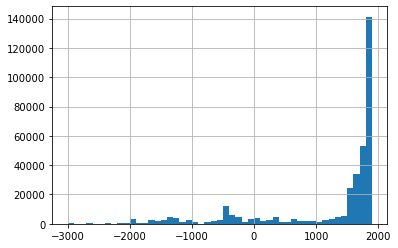

In [6]:
met_dataset['Object End Date'].hist(bins = np.arange(-3000, 2000, 100))

In [7]:
(met_dataset["Object Begin Date"]<-3000).sum()

3815

In [8]:
(met_dataset["Object Begin Date"]>2000).sum()

2625

We can notice three main problems:

* the dataset contains a lot of null values
* each features has a lot of unique values
* the dataset is very much unbalanced : the majority of atworks has been created after year 1500. We will have to take this into account.

In [9]:
met_dataset['Classification'].unique()[:50]

array([nan, 'Metalwork-Brass', 'Metalwork-Pewter', 'Ceramics',
       'Textiles-Painted and Dyed', 'Armor Parts-Gorgets', 'Swords',
       'Armor Parts-Gauntlets', 'Fencing Equipment',
       'Sword Furniture-Tsuba', 'Daggers', 'Krisses', 'Shafted Weapons',
       'Armor Parts-Arms & Shoulders', 'Helmets', 'Firearms-Pistols',
       'Shields', 'Armor for Man-1/2 Armor', 'Firearms-Pistols-Flintlock',
       'Armor for Horse and Man', 'Firearms-Pistols-Wheellock',
       'Armor for Man', 'Archery Equipment-Crossbows', 'Armor Parts',
       'Combination Weapons', 'Knives', 'Firearms-Guns-Wheellock',
       'Miscellaneous', 'Firearms-Guns',
       'Firearms Accessories-Flasks & Primers',
       'Equestrian Equipment-Saddles', 'Miscellaneous-Badges',
       'Equestrian Equipment-Bits', 'Armor Parts-Backplates',
       'Armor Parts-Taces', 'Equestrian Equipment-Shaffrons',
       'Armor Parts-Masks', 'Armor Parts-Cuirasses',
       'Armor Parts-Breastplates', 'Mail', 'Banners', 'Armor for Ho

As we can see above there are very similar words : for example the "Armor" word is repeated multiple times. We could gather all these words into a main Classification value called "Armor".

We also have the same pattern with features Medium and Culture.



The Dimensions feature is a bit different : there are many more unique values.

In [10]:
met_dataset['Dimensions'].unique()[:10]

array(['Dimensions unavailable', 'Diam. 11/16 in. (1.7 cm)',
       'Diam. 1/2 in. (1.3 cm)', 'Diam. 1 1/8 in. (2.9 cm)',
       'Diam. 3/4 in. (1.9 cm)', 'Diam. 2 1/8 in. (5.4 cm)',
       '2 3/4 x 3 1/2 x 2 3/4 in. (7 x 8.9 x 7 cm)',
       '24 3/8 x 14 5/8 x 5 1/8 in. (61.9 x 37.1 x 13 cm)',
       'Overall: 19 7/16 x 13 x 9 1/4 in. (49.4 x 33 x 23.5 cm); 352 oz. 18 dwt. (10977 g)\r\nBody: H. 18 7/8 in. (47.9 cm)\r\nCover: 4 1/4 x 4 13/16 in. (10.8 x 12.2 cm); 19 oz. 6 dwt. (600.1 g)',
       '40 x 25 1/2 x 34 1/2 in. (101.6 x 64.8 x 87.6 cm)'], dtype=object)

Some objects, such as paintings, are 2 dimensional (height, width), whereas others, like sculptures, are 3 dimensionnal (height, width, depth). Some 2D objects, however, have the shape of a circle, so that they could be described by their diameter.

Hence, it could be more practical to encode the dimension feature into four features : height, diam, width, depth. Given the above remark, it follows there will necessarily be missing data: let's encode it by -1.

So first, there is a preprocessing work to do:

### $\textbf{Removing rows with nan values}$

We decided to remove all samples that presented missing values because we can not adopt a general preprocessing on NAN because those are information specific to an artwork

In [11]:
met_dataset = met_dataset.dropna(axis=0, subset=['Medium', 'Classification','Dimensions','Culture','Object Begin Date', 'Object End Date'])

In [12]:
met_dataset.shape

(138986, 6)

### $\textbf{Preprocessing of features}$

In [13]:
# classification column
Classification = prep_classification(met_dataset)

met_dataset['Classification'] = Classification
met_dataset[met_dataset['Classification']=='(not']=pd.NA
met_dataset = met_dataset.dropna(subset=['Classification'], axis=0)

In [14]:
# culture column

Culture = prep_culture(met_dataset)
met_dataset['Culture']=Culture

In [15]:
# Dimensions column

n = met_dataset.shape[0]
met_dataset["height"] = [-1]*n
met_dataset["width"] = [-1]*n
met_dataset["depth"] = [-1]*n
met_dataset["diam"] = [-1]*n

for id,description in zip(met_dataset.index, met_dataset["Dimensions"]):
  found_dims = find_dims(description)
  for k in found_dims.keys():
    if k in ["height", "width", "depth", "diam"]:
      met_dataset.loc[id,k] = found_dims[k]


In [16]:
met_dataset.drop('Dimensions', axis=1, inplace=True)

In [17]:
#creation of a colum Historical Period

met_dataset["Historical Period"] = prep_date(met_dataset)

In [18]:
met_dataset.drop(['Object Begin Date', "Object End Date"], axis =1 ,inplace=True)

We will not preprocess the Medium column because it is part of the challenge!

We get this final dataset:

In [19]:
met_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138967 entries, 4847 to 477572
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Medium             138967 non-null  object 
 1   Classification     138967 non-null  object 
 2   Culture            138967 non-null  object 
 3   height             138967 non-null  float64
 4   width              138967 non-null  float64
 5   depth              138967 non-null  float64
 6   diam               138967 non-null  float64
 7   Historical Period  138967 non-null  object 
dtypes: float64(4), object(4)
memory usage: 13.6+ MB


In [20]:
met_dataset.nunique()

Medium               25093
Classification         150
Culture               2127
height                2393
width                 2234
depth                 1781
diam                  1134
Historical Period        4
dtype: int64

### $\textbf{Creating training and test dataset}$

In [21]:
data_train, data_test = train_test_split(met_dataset, test_size=0.2, random_state=0)

In [22]:
data_train.to_csv("data/data_train.csv")
data_test.to_csv("data/data_test.csv")

# III - Model submission

#### 1. Workflow

The model works as follows :

* A feature extractor is used on the input to perform feature engineering. Two tasks must be done in the feature extractor. The first one is to preprocess the Medium column, we specially need to extract main features of each object in order to reduce the number of unique values in this column. Then, the second task is encode categorical columns.
* After the feature extraction, the generated features are fed to the classifier to generate a prediction

#### 2.1. Feature extractor

In [23]:
map_period = {"Contemporary Era":1., "Modern Times": 2., "Middle Ages":3., "Antiquity":4.}

def medium_extraction(X):
    val_medium = X['Medium'].values.copy()
    Medium = []
    sep = ","

    vectorizer = CountVectorizer(stop_words="english", max_features=24)
    vectorizer.fit(val_medium)
    vectorized_input = vectorizer.transform(val_medium)
    inv_transform = vectorizer.inverse_transform(vectorized_input)
            
    for arr in inv_transform:
        arr = list(arr)
        arr = sorted(arr)
        arr = sep.join(arr)
        Medium.append(arr)
            
    Medium = np.array(Medium)
    Medium[Medium==""]=pd.NA
            
    return Medium
        
def mean_target_encoding_classif(X):
    X["num_period"] = [map_period[period] for period in X['Historical Period']]
    tmp_classif = X.groupby(["Classification"]).describe()
    col_to_select = [col for col in tmp_classif.columns if "num_period" in col and "mean" in col][0]
    map_classif = {classif_cat: classif_num for (classif_cat, classif_num) in zip(tmp_classif.index, tmp_classif[col_to_select])}
            
    Classification = [map_classif[m] for m in X["Classification"]]
    return np.array(Classification).reshape(-1,1)
        
def mean_target_encoding_medium(X):
    X["num_period"] = [map_period[period] for period in X['Historical Period']]
    tmp_medium = X.groupby(["Medium"]).describe()
    col_to_select = [col for col in tmp_medium.columns if "num_period" in col and "mean" in col][0]
    map_medium = {medium_cat: medium_num for (medium_cat, medium_num) in zip(tmp_medium.index, tmp_medium[col_to_select])}
    Medium = [map_medium[m] for m in X["Medium"]]
    return np.array(Medium).reshape(-1,1)
        
def mean_target_encoding_culture(X):
    X["num_period"] = [map_period[period] for period in X['Historical Period']]
    tmp_culture = X.groupby(["Culture"]).describe()
    col_to_select = [col for col in tmp_culture.columns if "num_period" in col and "mean" in col][0]
    map_culture = {culture_cat: culture_num for (culture_cat, culture_num) in zip(tmp_culture.index, tmp_culture[col_to_select])}
            
    Culture = [map_culture[m] for m in X["Culture"]]
    return np.array(Culture).reshape(-1,1)
        
MTE_classif = FunctionTransformer(mean_target_encoding_classif, validate=False)
MTE_medium = FunctionTransformer(mean_target_encoding_medium, validate=False)
MTE_culture =  FunctionTransformer(mean_target_encoding_culture, validate=False)
        
#column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('medium_extraction', make_pipeline(MTE_medium, SimpleImputer(strategy="constant", fill_value=-1)), ['Medium', 'Historical Period']),
        ('mte_classif', MTE_classif, ['Classification', 'Historical Period']),
        ('mte_culture', MTE_culture,  ['Culture', 'Historical Period'])
    ])

data_train['Medium'] = medium_extraction(data_train)
preprocessor.fit(data_train, data_train['Historical Period'])
transformation = preprocessor.transform(data_train)
data_train[['Medium', 'Classification', 'Culture']] = transformation
if 'Unnamed:  0' in data_train.columns:
    data_train.drop(['Unnamed:  0'], axis=1, inplace=True)

X_train = data_train[['Medium', 'Classification', 'Culture', 'height', 'diam', 'width','depth']]
Y_train = data_train['Historical Period']

In [24]:
data_test['Medium'] = medium_extraction(data_test)
preprocessor.fit(data_test, data_test['Historical Period'])
transformation = preprocessor.transform(data_test)
data_test[['Medium', 'Classification', 'Culture']] = transformation
if 'Unnamed:  0' in data_test.columns:
    data_test.drop(['Unnamed:  0'], axis=1, inplace=True)

X_test = data_test[['Medium', 'Classification', 'Culture', 'height', 'diam', 'width','depth']]
Y_test = data_test['Historical Period']

#### 2.2. Data visualization

Now that the all variables are numerical we can make a bit of visualization on the training dataset:

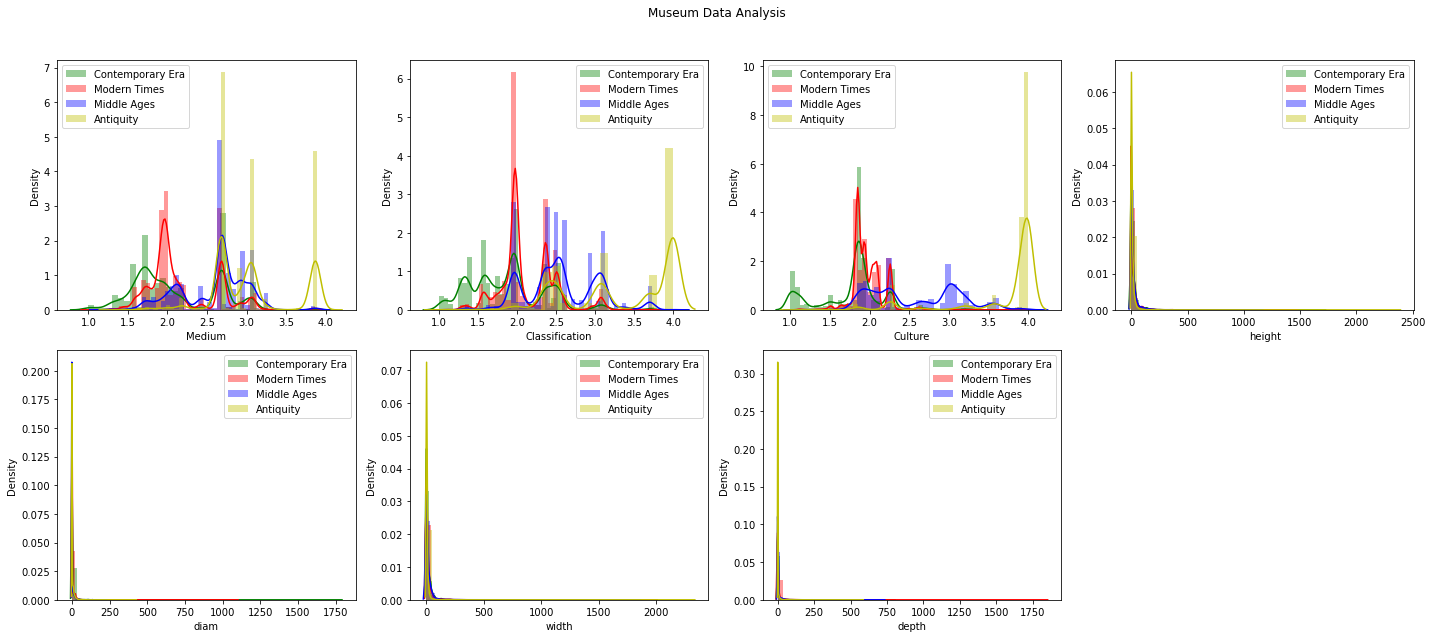

In [25]:
Target = Y_train 
fig = plt.figure(figsize = (20, 25))
j = 0
for i in X_train.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(X_train[i][Target=='Contemporary Era'], color='g', label = 'Contemporary Era')
    sns.distplot(X_train[i][Target=='Modern Times'], color='r', label = 'Modern Times')
    sns.distplot(X_train[i][Target=='Middle Ages'], color='b', label = 'Middle Ages')
    sns.distplot(X_train[i][Target=='Antiquity'], color='y', label = 'Antiquity')
    plt.legend(loc='best')
fig.suptitle('Museum Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

As we see there are many values for which dimension parameters (height, width, diam and width) are not provided. Therefore some missing values imputation may be useful. Now we visualize the distribution of known values (i.e. those that are greater than zero), limiting each of the dimensions to 50cm for better visualization.

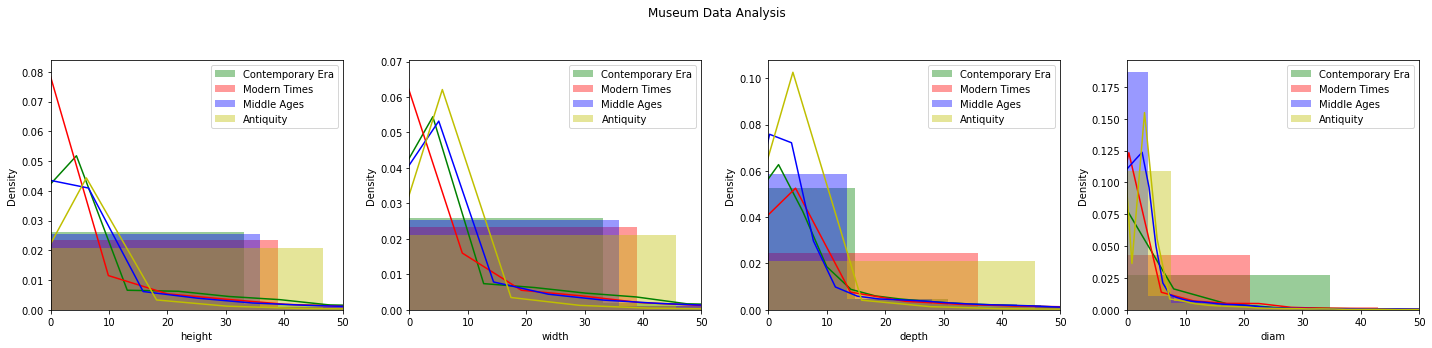

In [26]:
Target = Y_train
fig = plt.figure(figsize = (20, 25))
j = 0
for i in X_train[['height', 'width', 'depth','diam']].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    data = X_train[X_train[i] > 0]
    sns.distplot(data[Target=='Contemporary Era'], color='g', label = 'Contemporary Era')
    sns.distplot(data[Target=='Modern Times'], color='r', label = 'Modern Times')
    sns.distplot(data[Target=='Middle Ages'], color='b', label = 'Middle Ages')
    sns.distplot(data[Target=='Antiquity'], color='y', label = 'Antiquity')
    plt.xlim(0, 50)
    plt.xlabel(i)
    plt.legend(loc='best')
fig.suptitle('Museum Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### 2.3. Feature Selection & Correlation study

In this Study we will be testing three approaches, two are correlation based feature selection and the third one is using PCA

- Correlation allows to know how close two variables are to having a linear relationship with each other.
- When two features have high correlation, we can drop one of the two features.

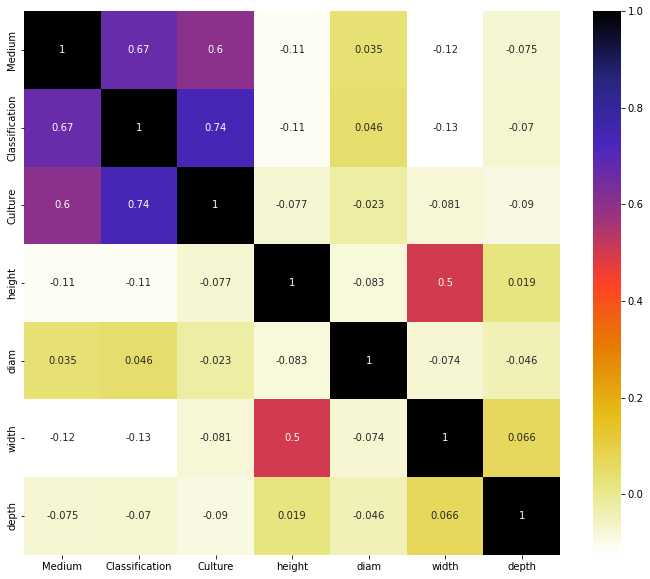

In [27]:
# Pearson correlation 
plt.figure(figsize=(12,10))
names = X_train.columns
df_train_cor = X_train.rename(columns={0:names[0], 1:names[1],2:names[2],3:names[3],4:names[4],5:names[5],6:names[6]})
# d_train.head()
cor = df_train_cor.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Now, let's see the correlation between features and the Target:

In [28]:
# Correlation of features with the target

y_df = Y_train.apply(lambda x: map_period[x])
cor_target = df_train_cor.corrwith(y_df)
cor_target

Medium            0.605723
Classification    0.720088
Culture           0.840827
height           -0.077649
diam             -0.022377
width            -0.075825
depth            -0.061491
dtype: float64

* Based on the correlation between features, we can notice a high correalation between medium_num & classif_num & culture_num, and a lower correlation between width and height. 

* Based on the correlation between features and the Target, we notice a significant correlation with the target of medium_num & classif_num & culture_num features, whereas, the other features have a very low and negative correlation with the target. This means that the features that may significantly impact the classification results would be the ones that are highly correlated with the target.


#### 3. Baseline Classifier

In [29]:
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0)
model.fit(X_train, Y_train)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy', n_jobs=-1)
scores.mean()

0.8633235889363615

In [30]:
def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    
    preds = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True, xticklabels=map_period.keys(),
    yticklabels=map_period.keys(),
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

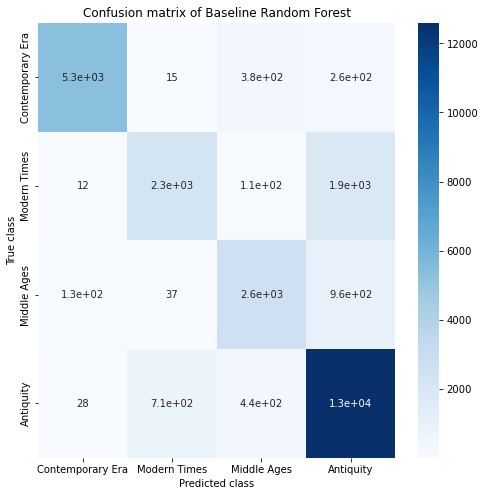

In [31]:
plot_confusion_matrix(model, X_test, Y_test, model_name="Baseline Random Forest")

#### Submission
Before submitting make sure to test your model and check that everything works fine. 
In order to do that you can run : 

`ramp_test_submission --submission starting_kit` 

or for a quick test : 

`ramp_test_submission --submission starting_kit --quick-test`


Notice that this unit test run in the folder submissions/starting_kit.

Before running the test, make sure you have :
* Installed ramp-workflow.
* Installed the requirements ( `pip install -r requirements.txt` ).
* Put your solution files (feature extractor and a classifier) under the `submissions/starting_kit` folder.

